In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import warnings
import platform
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
#from fastFM import als
import scipy
import sys
import time
import xlearn as xl
%matplotlib inline
warnings.filterwarnings("ignore")

/Users/she/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
mod = [np, pd, matplotlib, sklearn, sns]
mod_str = ['numpy', 'pandas', 'matplotlib', 'sklearn', 'seaborn']
max_len = max(len(i)for i in mod_str)
print("{{:<{}}} version: {{}}".format(max_len).format('Platform', platform.platform()))
print("{{:<{}}} version: {{}}".format(max_len).format('Python',sys.version))
for m, ms in zip(mod, mod_str):
    print("{{:<{}}} version: {{.__version__}}".format(max_len).format(ms,m))

Platform   version: Darwin-18.2.0-x86_64-i386-64bit
Python     version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
numpy      version: 1.14.6
pandas     version: 0.23.4
matplotlib version: 3.0.1
sklearn    version: 0.20.0
seaborn    version: 0.9.0


# Data Exploration

In [311]:
pd.read_excel('Data_Dictionary.xlsx', sheet_name='train')

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [3]:
train = pd.read_csv("train.csv", parse_dates=['first_active_month'])

           feature_1  feature_2  feature_3    target
feature_1   1.000000  -0.130969   0.583092 -0.014251
feature_2  -0.130969   1.000000   0.060925 -0.006242
feature_3   0.583092   0.060925   1.000000 -0.008125
target     -0.014251  -0.006242  -0.008125  1.000000


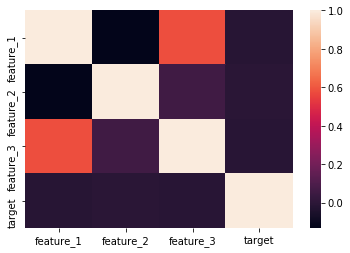

In [208]:
print(train.corr())
sns.heatmap(train.corr())

In [312]:
train.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [315]:
pd.read_csv("historical_transactions.csv").info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [317]:
pd.read_excel('Data_Dictionary.xlsx', sheet_name='history')

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


## train----target

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64


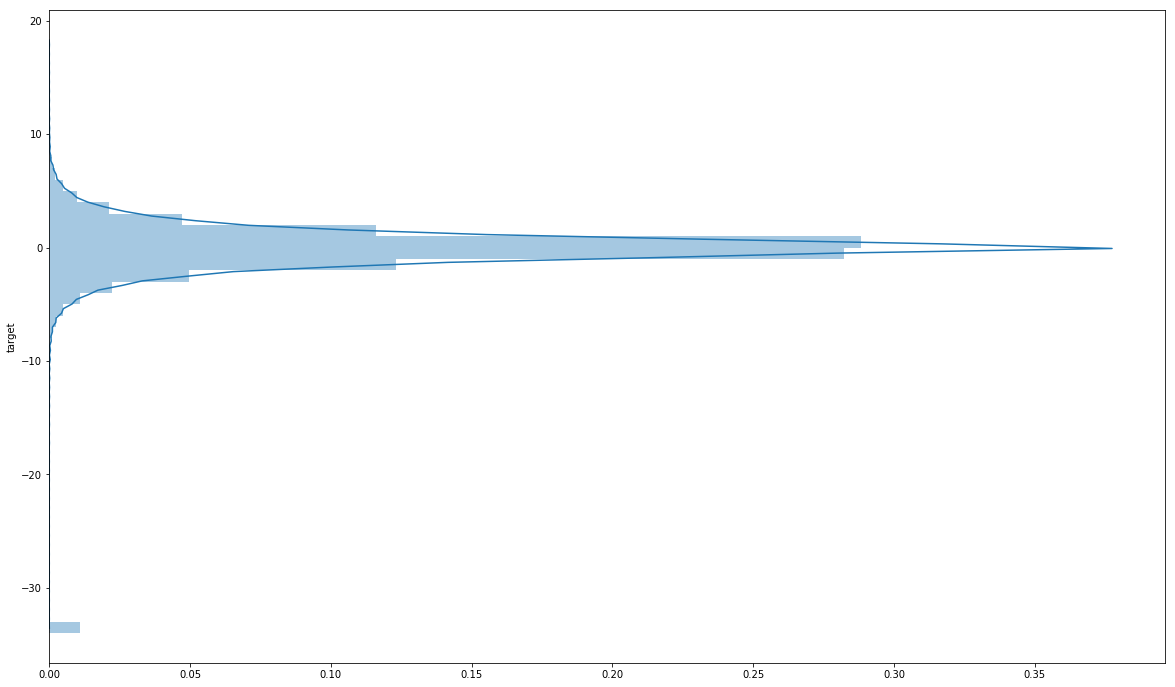

In [110]:
print(train.target.describe())
plt.figure(figsize=(20,12))
sns.distplot(train.target, bins=np.arange(-34, 19, 1), vertical=True)

In [7]:
print(train.target[train.target>-30].describe())

count    199710.000000
mean         -0.030879
std           1.717793
min         -17.608147
25%          -0.844513
50%          -0.007783
75%           0.777331
max          17.965068
Name: target, dtype: float64


In [11]:
train.target[train.target<-20].value_counts()

-33.219281    2207
Name: target, dtype: int64

In [13]:
2207/199710

0.011051023984777928

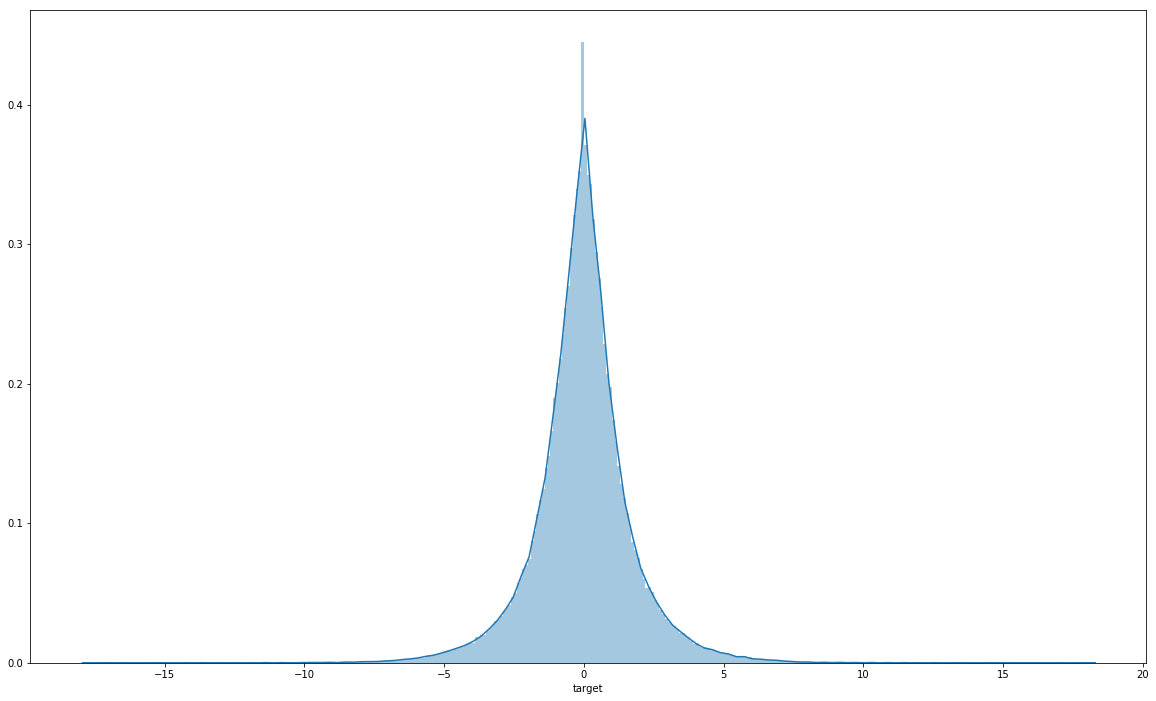

In [22]:
plt.figure(figsize=(20,12))
sns.distplot(train.target[train.target>-30], bins=np.arange(-18, 18, 0.1))

## Features 1, 2, 3

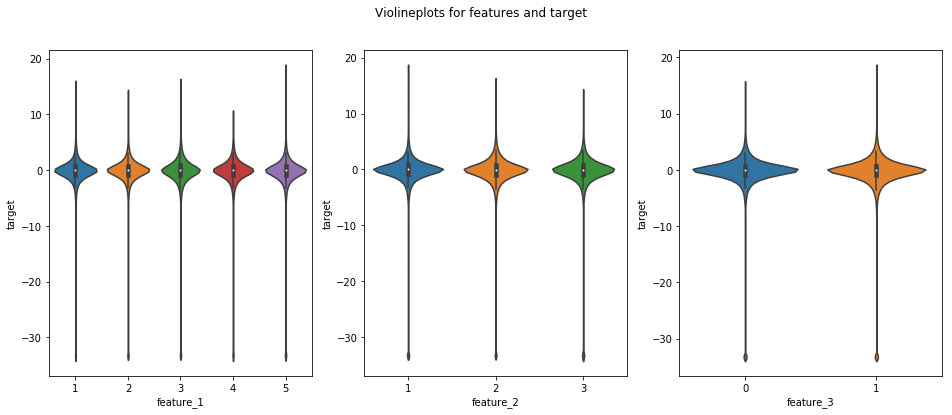

In [313]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

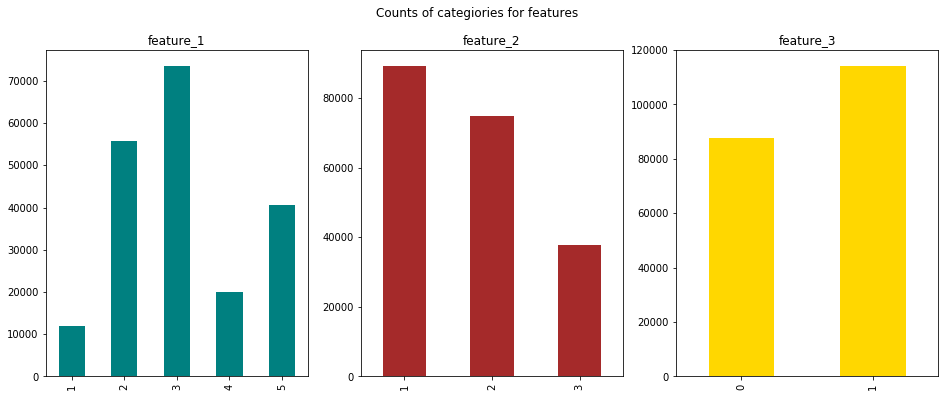

In [314]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

## train----first_active_month

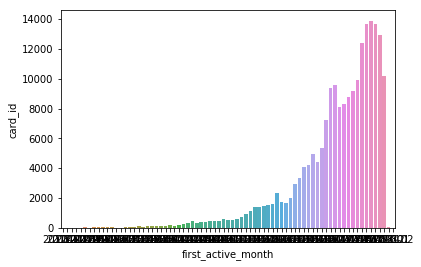

In [205]:
sns.barplot(train.groupby(["first_active_month"]).count().index, \
            train.groupby(["first_active_month"]).count().card_id)

Text(0.5, 1.0, 'First active month count in target low than -30')

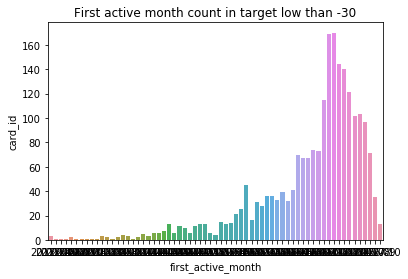

In [223]:
sns.barplot(train[train['target']<-30].groupby(["first_active_month"]).count().index, \
            train[train['target']<-30].groupby(["first_active_month"]).count().card_id)
plt.title("First active month count in target low than -30")

## historical_transactions--card_id

In [2]:
ht = pd.read_csv("historical_transactions.csv", error_bad_lines=False)

In [3]:
ht.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [4]:
ht.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [56]:
series_ht_cardid_count = ht.card_id.value_counts()

In [58]:
series_ht_cardid_count.values

array([5582, 2912, 2143, ...,    2,    2,    2])

In [79]:
ht_cardid_count = pd.DataFrame([series_ht_cardid_count.index, series_ht_cardid_count.values]).T

In [103]:
ht_cardid_count.rename(columns={0: "card_id", 1: "ht_cardid_counts"}, inplace=True)
ht_cardid_count.head()

,card_id,ht_cardid_counts
0,C_ID_3d3dfdc692,5582
1,C_ID_0cd2ce025c,2912
2,C_ID_cc3d4cd4e3,2143
3,C_ID_5ccc07beb9,2066
4,C_ID_5ea401d358,1786


In [104]:
train_ht_merge = pd.merge(train[["card_id", "target"]], ht_cardid_count, 'left', 'card_id')
train_ht_merge.head()

,card_id,target,ht_cardid_counts
0,C_ID_92a2005557,-0.820283,260
1,C_ID_3d0044924f,0.392913,350
2,C_ID_d639edf6cd,0.688056,43
3,C_ID_186d6a6901,0.142495,77
4,C_ID_cdbd2c0db2,-0.159749,133


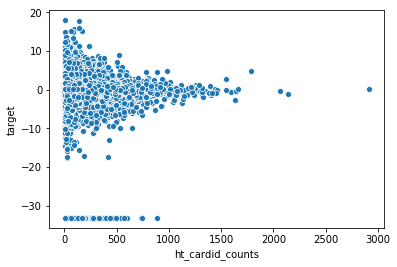

In [89]:
sns.scatterplot(train_ht_merge["ht_cardid_counts"], train_ht_merge["target"])

## Missing value

In [225]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [227]:
ht.isnull().sum()
total = ht.isnull().sum().sort_values(ascending = False)
percent = (ht.isnull().sum()/ht.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
category_2,2652864,9.112500
category_3,178159,0.611970
merchant_id,138481,0.475678
subsector_id,0,0.000000
state_id,0,0.000000
purchase_date,0,0.000000
purchase_amount,0,0.000000
month_lag,0,0.000000
merchant_category_id,0,0.000000
installments,0,0.000000


## historical_transactions----month_lag

-2     3857276
-1     3627430
 0     3470946
-3     3095651
-4     2639805
-5     2364790
-6     2050048
-7     1769844
-8     1427846
-9     1234724
-10    1085053
-11    1007878
-12     791973
-13     689097
Name: month_lag, dtype: int64


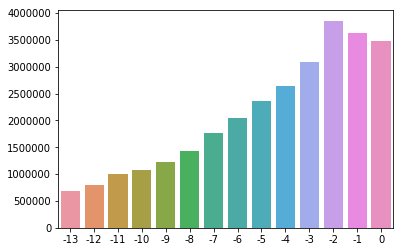

In [232]:
print(ht.month_lag.value_counts())
sns.barplot(x=ht.month_lag.value_counts().index, y=ht.month_lag.value_counts().values,)

## historical_transactions----purchase_date

In [236]:
ht["purchase_date"].head()

0    2017-06-25 15:33:07
1    2017-07-15 12:10:45
2    2017-08-09 22:04:29
3    2017-09-02 10:06:26
4    2017-03-10 01:14:19
Name: purchase_date, dtype: object

## historical_transactions----authorized_flag

Y    26595452
N     2516909
Name: authorized_flag, dtype: int64


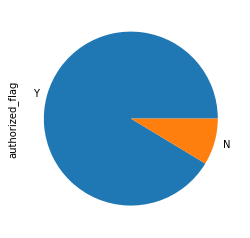

In [256]:
print(ht.authorized_flag.value_counts())
ht.authorized_flag.value_counts().plot(kind="pie")

## historical_transactions----category_3

A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64


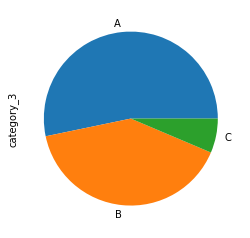

In [257]:
print(ht.category_3.value_counts())
ht.category_3.value_counts().plot(kind="pie")

## historical_transactions----category_1

N    27028332
Y     2084029
Name: category_1, dtype: int64


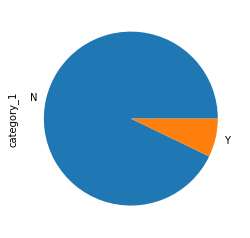

In [258]:
print(ht.category_1.value_counts())
ht.category_1.value_counts().plot(kind="pie")

## historical_transactions----category_2

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64


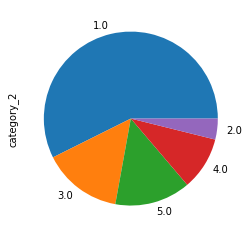

In [259]:
print(ht.category_2.value_counts())
ht.category_2.value_counts().plot(kind="pie")

In [261]:
print(ht.installments.value_counts())

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64


## historical_transactions----installments

In [293]:
inst_target = pd.merge(train[["card_id", "target"]], ht[["card_id", "installments"]], "left", "card_id").groupby("installments").mean()
inst_target.T

installments,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,999
target,-0.198545,-0.326016,-0.587727,-0.584338,-0.576481,-0.538817,-0.562405,-0.547366,-0.71256,-0.563364,-0.591758,-0.567902,-0.742808,-0.784036,-0.835092


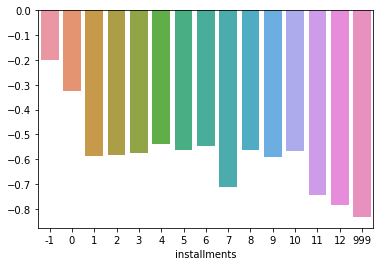

In [292]:
sns.barplot(inst_target.index, inst_target.values.reshape((15,)))

## historical_transactions----merchant_category_id

In [296]:
ht.merchant_category_id.value_counts()

705    5554009
307    3057930
278    2254227
80     1929413
367    1608239
879    1430607
560    1110681
683     822021
437     665634
690     459101
839     445622
884     416465
108     317938
842     315091
511     302620
68      300512
506     292335
755     290310
222     290186
561     272565
454     259206
422     249513
195     227402
45      225705
360     225270
309     222541
661     210774
557     190599
87      179321
818     178481
        ...   
714         30
587         27
27          25
530         25
464         14
718         12
67          12
145         11
579          9
153          9
59           7
817          6
523          6
226          6
741          6
268          5
18           4
805          3
601          3
37           3
634          3
266          2
603          2
164          2
875          1
311          1
322          1
882          1
86           1
687          1
Name: merchant_category_id, Length: 327, dtype: int64

## historical_transactions----city_id

In [298]:
ht.city_id.value_counts()

 69     4835441
-1      2478624
 19     1151077
 158    1113013
 17      971714
 331     714414
 143     668769
 88      659328
 137     603023
 333     561144
 87      444940
 212     406196
 57      382232
 149     359540
 25      356757
 233     355108
 117     322414
 160     317617
 213     248371
 277     247294
 286     231877
 76      216048
 4       212403
 107     210182
 53      209668
 20      207650
 291     199983
 140     190359
 344     177694
 161     168745
         ...   
 32        8382
 81        8278
 54        8201
 235       7918
 326       7912
 293       7804
 327       7499
 112       7461
 84        7367
 237       7285
 227       7233
 254       7143
 71        6781
 204       6745
 306       6128
 221       6096
 130       5657
 122       5458
 205       5385
 215       4791
 89        4760
 178       4430
 263       4003
 207       3905
 315       3845
 319       1645
 92         758
 273        620
 316        149
 185         45
Name: city_id, Length: 3

## historical_transactions----state_id

In [299]:
ht.state_id.value_counts()

 9     10568881
-1      2652864
 16     2143420
 15     2079255
 5      1655124
 19     1204287
 20     1141197
 22      971714
 21      929594
 4       840820
 7       640712
 13      634006
 11      631127
 3       542220
 12      385643
 18      384876
 2       371728
 1       247753
 10      222463
 23      206011
 24      205952
 14      171513
 8       157829
 17      116139
 6         7233
Name: state_id, dtype: int64

# Feature Engineering

In [660]:
train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('test.csv', parse_dates=['first_active_month'])
historical_transactions = pd.read_csv('historical_transactions.csv',parse_dates=['purchase_date'])
new_transactions = pd.read_csv('new_merchant_transactions.csv',parse_dates=['purchase_date'])

In [661]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [662]:
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['elapsed_time'].head() 

0    245
1    396
2    549
3    153
4     92
Name: elapsed_time, dtype: int64

In [663]:
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['elapsed_time'].head() 

0    306.0
1    396.0
2    184.0
3     62.0
4    793.0
Name: elapsed_time, dtype: float64

In [664]:
Y_train = train['target']
del train['target']

In [665]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [666]:
historical_transactions['month_diff'] = ((datetime.datetime.today() \
                                          - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

In [667]:
new_transactions['month_diff'] = ((datetime.datetime.today() \
                                   - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [668]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,10
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,10
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,11
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,11
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,11


In [669]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [671]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [672]:
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

In [673]:
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [674]:
authorized_transactions.shape

(26595452, 21)

In [675]:
historical_transactions.shape

(2516909, 21)

In [676]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [677]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [678]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history.head()

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,10.514286
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,10.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,10.500000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,14.444444
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,10.285714


In [679]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

In [680]:
authorized.head()

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,10.605263
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,10.283333
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,10.661290
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,14.386243
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,10.503650


In [681]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [682]:
new.head()

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,11.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,10.192308
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,10.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,14.032258
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,10.727273


In [683]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [684]:
final_group =  aggregate_per_month(authorized_transactions) 
final_group.head()

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529


In [685]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [686]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [687]:
print(additional_fields.columns)
additional_fields.head()

Index(['card_id', 'category_1_purchase_amount_mean',
       'category_1_purchase_amount_min', 'category_1_purchase_amount_max',
       'category_1_purchase_amount_std', 'installments_purchase_amount_mean',
       'installments_purchase_amount_min', 'installments_purchase_amount_max',
       'installments_purchase_amount_std', 'city_id_purchase_amount_mean',
       'city_id_purchase_amount_min', 'city_id_purchase_amount_max',
       'city_id_purchase_amount_std', 'category_1_installments_mean',
       'category_1_installments_min', 'category_1_installments_max',
       'category_1_installments_std'],
      dtype='object')


,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.671875,-0.656738,0.010704,1.000000,1.000000,1.000000,NaN
1,C_ID_0001238066,-0.607422,-0.650391,-0.564453,0.06076,-0.423828,-0.625977,-0.151978,0.222046,-0.558105,-0.666992,-0.472168,0.072632,2.479167,1.458333,3.500000,1.443676
2,C_ID_0001506ef0,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,0.000000,0.000000,0.000000,NaN
3,C_ID_0001793786,-0.007385,-0.007385,-0.007385,NaN,-0.007385,-0.007385,-0.007385,NaN,-0.247070,-0.572754,0.249268,0.346924,0.000000,0.000000,0.000000,NaN
4,C_ID_000183fdda,-0.599121,-0.599121,-0.599121,NaN,-0.491211,-0.696289,-0.107666,0.233887,-0.572266,-0.604980,-0.539062,0.046600,1.454545,1.454545,1.454545,NaN


# Training the model

In [688]:
# merge all the dataframes
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [689]:
print(train.shape)
train.columns

(201917, 163)


Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'elapsed_time', 'hist_transactions_count', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_category_2_1.0_mean',
       ...
       'installments_purchase_amount_max', 'installments_purchase_amount_std',
       'city_id_purchase_amount_mean', 'city_id_purchase_amount_min',
       'city_id_purchase_amount_max', 'city_id_purchase_amount_std',
       'category_1_installments_mean', 'category_1_installments_min',
       'category_1_installments_max', 'category_1_installments_std'],
      dtype='object', length=163)

In [99]:
test.to_csv('final_test.csv')
train.to_csv('final_train.csv')

In [657]:
train = pd.read_csv('final_train.csv', index_col=0)
test = pd.read_csv('final_test.csv', index_col=0)
target = pd.read_csv("train.csv")['target']

In [659]:
train.shape

(201917, 165)

In [690]:
train["elapsed_mon"] = pd.cut(train.elapsed_time, np.arange(0, 2290, 24*10), labels=np.arange(9))

In [691]:
test["elapsed_mon"] = pd.cut(test.elapsed_time, np.arange(0, 2290, 24*10), labels=np.arange(9))

In [692]:
train["elapsed_hour"] = train.elapsed_time.map(lambda x: x%24//2)

In [693]:
test["elapsed_hour"] = test.elapsed_time.map(lambda x: x%24//2)

In [694]:
train.to_csv("final_train.csv")
test.to_csv("final_test.csv")
target.to_csv("target.csv")

In [695]:
train_without31 = train[(target>-30)]
test_without31 = test[(target>-30)]
target_without31 = target[(target>-30)]

In [696]:
train_without31.to_csv("final_train_without31.csv")
test_without31.to_csv("final_test_without31.csv")
target_without31.to_csv("target_without31.csv")

In [540]:
target_less31_bool = target<-30
target_less31_bool.to_csv("target_less31_bool.csv")

In [537]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_1','feature_2', 'feature_3',"elapsed_mon", "elapsed_hour"]

## lightgbm

In [246]:
train = pd.read_csv('final_train.csv', index_col=0)
test = pd.read_csv('final_test.csv', index_col=0)
target = pd.read_csv("train.csv")['target']

In [251]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
# https://www.kaggle.com/fabiendaniel/hyperparameter-tuning

In [252]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71396	valid_1's rmse: 3.77557
[200]	training's rmse: 3.64386	valid_1's rmse: 3.72718
[300]	training's rmse: 3.6004	valid_1's rmse: 3.70353
[400]	training's rmse: 3.5687	valid_1's rmse: 3.69146
[500]	training's rmse: 3.54469	valid_1's rmse: 3.68453
[600]	training's rmse: 3.52454	valid_1's rmse: 3.68037
[700]	training's rmse: 3.50787	valid_1's rmse: 3.67745
[800]	training's rmse: 3.49281	valid_1's rmse: 3.67555
[900]	training's rmse: 3.47854	valid_1's rmse: 3.67394
[1000]	training's rmse: 3.46615	valid_1's rmse: 3.6729
[1100]	training's rmse: 3.45387	valid_1's rmse: 3.67208
[1200]	training's rmse: 3.4423	valid_1's rmse: 3.67147
[1300]	training's rmse: 3.43044	valid_1's rmse: 3.67089
[1400]	training's rmse: 3.41975	valid_1's rmse: 3.67029
[1500]	training's rmse: 3.40948	valid_1's rmse: 3.66992
[1600]	training's rmse: 3.3993	valid_1's rmse: 3.66995
[1700]	training's rmse: 3.38932	valid_1's rmse

In [253]:
np.save("predictions_lgbm_5.npy", predictions)

In [ ]:
np.argsort(clf.predict(train[features], num_iteration=clf.best_iteration))

In [277]:
target[np.argsort(clf.predict(train[features], num_iteration=clf.best_iteration))][:1000]

171585   -33.219281
42753    -33.219281
25880    -33.219281
25347    -33.219281
161607   -33.219281
13101    -33.219281
17724    -33.219281
128262   -33.219281
156077   -33.219281
12602    -33.219281
135378   -33.219281
159259   -33.219281
60491      0.632296
2170      -0.147904
47385    -33.219281
88227    -33.219281
160797   -33.219281
148428   -33.219281
9528     -33.219281
22633    -33.219281
16989    -33.219281
73174    -33.219281
160204   -33.219281
156580   -33.219281
186912   -33.219281
179088   -33.219281
65839    -33.219281
85329    -33.219281
139384   -33.219281
182878   -33.219281
            ...    
198153     2.488296
150195     1.031589
200806    -1.234421
35182    -33.219281
126140   -33.219281
142043   -33.219281
11510     -0.894558
3271      -4.014950
51317     -1.155588
85665    -33.219281
49246      0.080121
114335    -1.000307
84367     -0.883689
167471     0.746667
153398     0.207543
95223    -33.219281
141269   -33.219281
41212    -33.219281
182253    -0.077918


In [276]:
(target<-10).sum()

2264

In [262]:
(predictions).std()

1.1560921306116398

In [266]:
target[target>-20].std()

1.7177929279593622

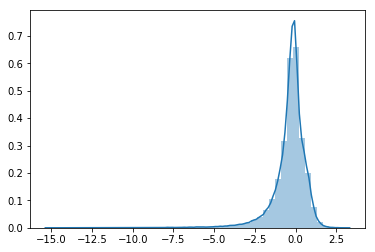

In [255]:
sns.distplot(predictions)

In [256]:
joblib.dump(clf,'lgb_5.pkl')

['lgb_5.pkl']

In [727]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_without31))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_without31.values, target_without31.values)):
    print("fold n {}".format(fold_))
    trn_data = lgb.Dataset(train_without31.iloc[trn_idx][features],
                           label=target_without31.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_without31.iloc[val_idx][features],
                           label=target_without31.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_without31.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target_without31)**0.5))

fold n 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.62766	valid_1's rmse: 1.64064
[200]	training's rmse: 1.58421	valid_1's rmse: 1.60518
[300]	training's rmse: 1.55999	valid_1's rmse: 1.58792
[400]	training's rmse: 1.54432	valid_1's rmse: 1.57858
[500]	training's rmse: 1.53269	valid_1's rmse: 1.57309
[600]	training's rmse: 1.52331	valid_1's rmse: 1.5696
[700]	training's rmse: 1.51547	valid_1's rmse: 1.5673
[800]	training's rmse: 1.50844	valid_1's rmse: 1.56569
[900]	training's rmse: 1.5026	valid_1's rmse: 1.56455
[1000]	training's rmse: 1.49733	valid_1's rmse: 1.56368
[1100]	training's rmse: 1.49255	valid_1's rmse: 1.56314
[1200]	training's rmse: 1.4882	valid_1's rmse: 1.56273
[1300]	training's rmse: 1.48421	valid_1's rmse: 1.56237
[1400]	training's rmse: 1.48021	valid_1's rmse: 1.56216
[1500]	training's rmse: 1.47668	valid_1's rmse: 1.56203
[1600]	training's rmse: 1.47293	valid_1's rmse: 1.5619
[1700]	training's rmse: 1.46971	valid_1's rmse

In [728]:
np.save("predictions_lgbm_without_31_1.npy", predictions)

In [731]:
predictions

array([-0.53107655, -0.30205992, -0.70470531, ...,  1.1530389 ,
       -0.78804415,  0.2466566 ])

In [267]:
np.load("predictions_lgbm_without_31_1.npy").std()

0.720805856981275

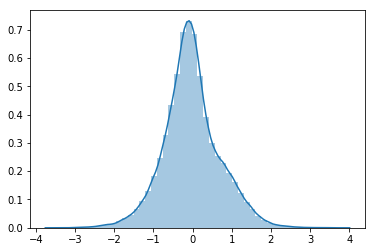

In [729]:
sns.distplot(predictions)

In [730]:
joblib.dump(clf,'lgb_without_31_1.pkl')

['lgb_without_31_1.pkl']

## Classification


In [333]:
train = pd.read_csv('final_train.csv', index_col=0)
test = pd.read_csv('final_test.csv', index_col=0)
target = pd.read_csv("target_less31_bool.csv", index_col=0, header=None).astype("int")[1]

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 70.29 Mb (72.5% reduction)
Mem. usage decreased to 42.44 Mb (72.9% reduction)


In [18]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_1','feature_2', 'feature_3',"elapsed_mon", "elapsed_hour"]

In [21]:
train_cla90 = train.copy()
target_cla90 = target.copy()
train_31 = train[pd.read_csv("train.csv").target<-30]
target_31 = target[pd.read_csv("train.csv").target<-30]
for i in range(90):
    train_cla90 = pd.concat([train_cla90, train_31], axis=0)
    target_cla90 = pd.concat([target_cla90, target_31], axis=0)
    if i%10 ==0:
        print(i)
print("Done!")
del train_31
del target_31

0
10
20
30
40
50
60
70
80
Done!


In [22]:
train_cla90 = reduce_mem_usage(train_cla90)

Mem. usage decreased to 139.43 Mb (72.5% reduction)


In [23]:
train_cla90.to_csv("train_cla90.csv")
target_cla90.to_csv("target_cla90.csv")

In [38]:
# x_train, x_test, y_train, y_test = train_test_split(train[features], target_1)

In [34]:
# def fill_nan(df):
#     nan_count =  df.isna().sum(axis=0)
#     nan_cols = nan_count[nan_count !=0].index
#     for c in nan_cols:
#         df[c].fillna(df[c][df[c].notna()].mean(), inplace=True)

In [51]:
# fill_nan(x_train)
# fill_nan(x_test)

In [388]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'binary',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.2634,
         "random_state": 36,
         "verbosity": -1}

In [163]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 36,
         "verbosity": -1}

In [590]:
# param = {'num_leaves': 197,
#          'min_data_in_leaf': 93, 
#          'objective':'binary',
#          'max_depth': 11,
#          'learning_rate': 0.01,
#          "boosting": "gbdt",
#          "feature_fraction": 0.7522,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.7083 ,
#          "bagging_seed": 11,
#          "metric": 'binary_logloss',
#          "lambda_l1": 0.2634,
#          "random_state": 133,
#          "verbosity": -1}

In [380]:
train = pd.read_csv('train_cla90.csv', index_col=0)
test = pd.read_csv('final_test.csv', index_col=0)
target = pd.read_csv("target_cla90.csv", index_col=0).target

In [ ]:
train = pd.read_csv('final_train.csv', index_col=0)
test = pd.read_csv('final_test.csv', index_col=0)
target = pd.read_csv("target_less31_bool.csv", index_col=0, header=None).astype("int")[1]

In [381]:
train, val_train, target,  val_target =  train_test_split(train, target, \
                                            test_size = 0.3, random_state=37, shuffle=True)

In [382]:
train.shape, target.shape, val_train.shape, val_target.shape

((280382, 165), (280382,), (120165, 165), (120165,))

In [383]:
(target==0).sum()/(target==1).sum()

0.9948205328874817

In [395]:
folds = KFold(n_splits=5, shuffle=True, random_state=127)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
# feature_importance_df = pd.DataFrame()
clfs = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 5000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    clfs.append(clf)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n 0
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.95193	valid_1's auc: 0.948917
[200]	training's auc: 0.95724	valid_1's auc: 0.954276
[300]	training's auc: 0.962307	valid_1's auc: 0.959356
[400]	training's auc: 0.967153	valid_1's auc: 0.964168
[500]	training's auc: 0.971056	valid_1's auc: 0.968093
[600]	training's auc: 0.974529	valid_1's auc: 0.971599
[700]	training's auc: 0.977612	valid_1's auc: 0.974768
[800]	training's auc: 0.980113	valid_1's auc: 0.97733
[900]	training's auc: 0.982342	valid_1's auc: 0.979613
[1000]	training's auc: 0.983879	valid_1's auc: 0.981188
[1100]	training's auc: 0.985263	valid_1's auc: 0.982574
[1200]	training's auc: 0.986909	valid_1's auc: 0.984242
[1300]	training's auc: 0.988721	valid_1's auc: 0.986101
[1400]	training's auc: 0.99031	valid_1's auc: 0.987762
[1500]	training's auc: 0.991716	valid_1's auc: 0.989232
[1600]	training's auc: 0.992893	valid_1's auc: 0.990496
[1700]	training's auc: 0.993992	valid_1's auc

[4100]	training's auc: 0.999948	valid_1's auc: 0.999724
[4200]	training's auc: 0.99996	valid_1's auc: 0.999765
[4300]	training's auc: 0.999968	valid_1's auc: 0.999799
[4400]	training's auc: 0.999975	valid_1's auc: 0.999827
[4500]	training's auc: 0.99998	valid_1's auc: 0.999848
[4600]	training's auc: 0.999984	valid_1's auc: 0.999871
[4700]	training's auc: 0.999988	valid_1's auc: 0.999889
[4800]	training's auc: 0.999991	valid_1's auc: 0.999906
[4900]	training's auc: 0.999993	valid_1's auc: 0.999923
[5000]	training's auc: 0.999995	valid_1's auc: 0.999935
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.999995	valid_1's auc: 0.999935
fold n 3
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.950306	valid_1's auc: 0.949163
[200]	training's auc: 0.956444	valid_1's auc: 0.955468
[300]	training's auc: 0.961539	valid_1's auc: 0.960624
[400]	training's auc: 0.966589	valid_1's auc: 0.965682
[500]	training's auc: 0.970776	valid_1's auc: 

In [396]:
pr = sum([clf.predict(val_train[features], num_iteration=clf.best_iteration)/len(clfs) for clf in clfs])

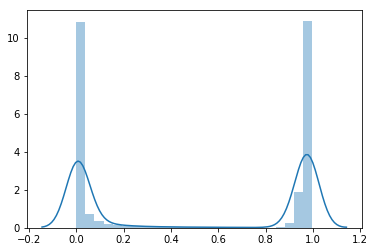

In [401]:
sns.distplot(pr)

In [402]:
pr[np.argsort(pr)][::-1][val_target.sum()]

0.868597310674048

In [404]:
(pr>0.868597310674048).sum(), val_target.sum()

(60260, 60282)

In [405]:
confusion_matrix(val_target, pr>0.868597310674048)

array([[59792,    91],
       [  113, 60169]])

In [408]:
joblib.dump(clfs,'clafs_auc_1.pkl')

['clafs_auc_1.pkl']

In [407]:
np.save("cla_auc_1.npy", pr)

In [406]:
target_bool = (pd.read_csv("train.csv").target<-31).astype(int)

In [149]:
# clfs = joblib.load('clafs_logloss6.pkl')

In [410]:
pr = sum([clf.predict(pd.read_csv("final_train.csv")[features], \
                      num_iteration=clf.best_iteration)/len(clfs) for clf in clfs])

In [425]:
confusion_matrix(pr>0.908, target_bool)

array([[199653,     23],
       [    57,   2184]])

In [426]:
pr_test = sum([clf.predict(pd.read_csv("final_test.csv")[features], \
                      num_iteration=clf.best_iteration)/len(clfs) for clf in clfs])

In [429]:
(pd.read_csv("train.csv").target<-30).sum()/len(pd.read_csv("train.csv"))*len(pd.read_csv("test.csv"))

1351.2282819178176

In [427]:
(pr_test>0.908).sum()

122

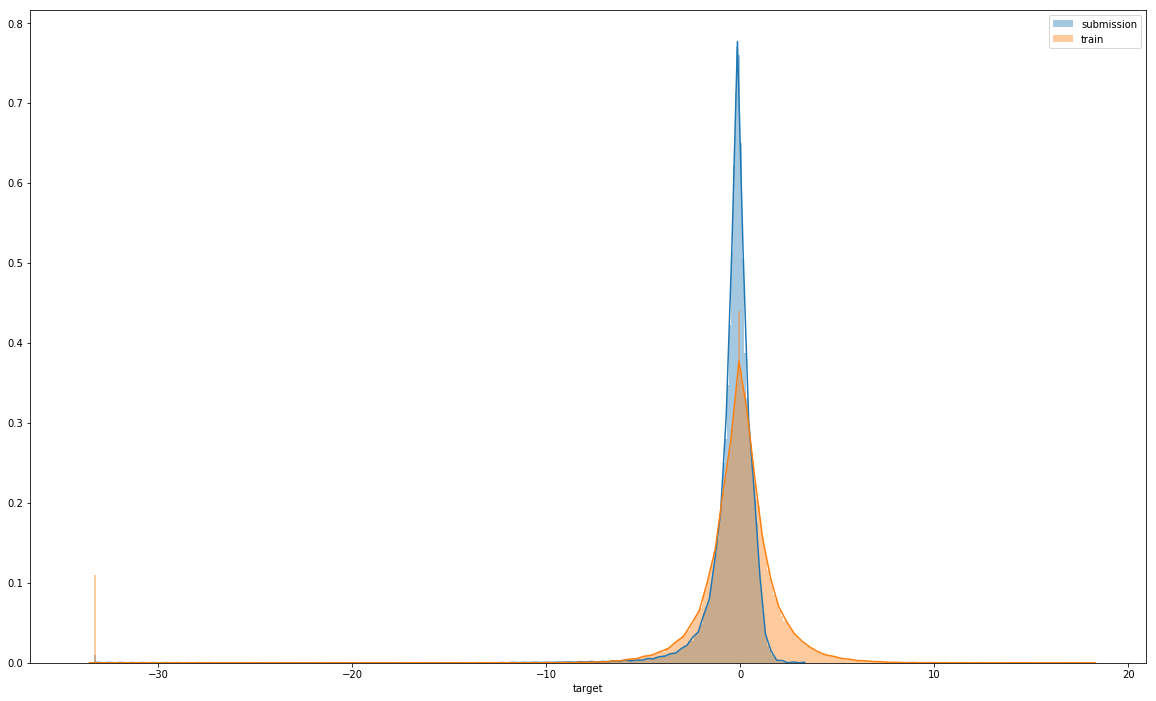

In [446]:
submit_with_lgbm(pr_test>0.908,"submission15_908_.csv")

In [431]:
pr_test[pr_test.argsort()][::-1][1351]

0.6440641132742975

In [435]:
(pr_test>0.6441).sum()

1351

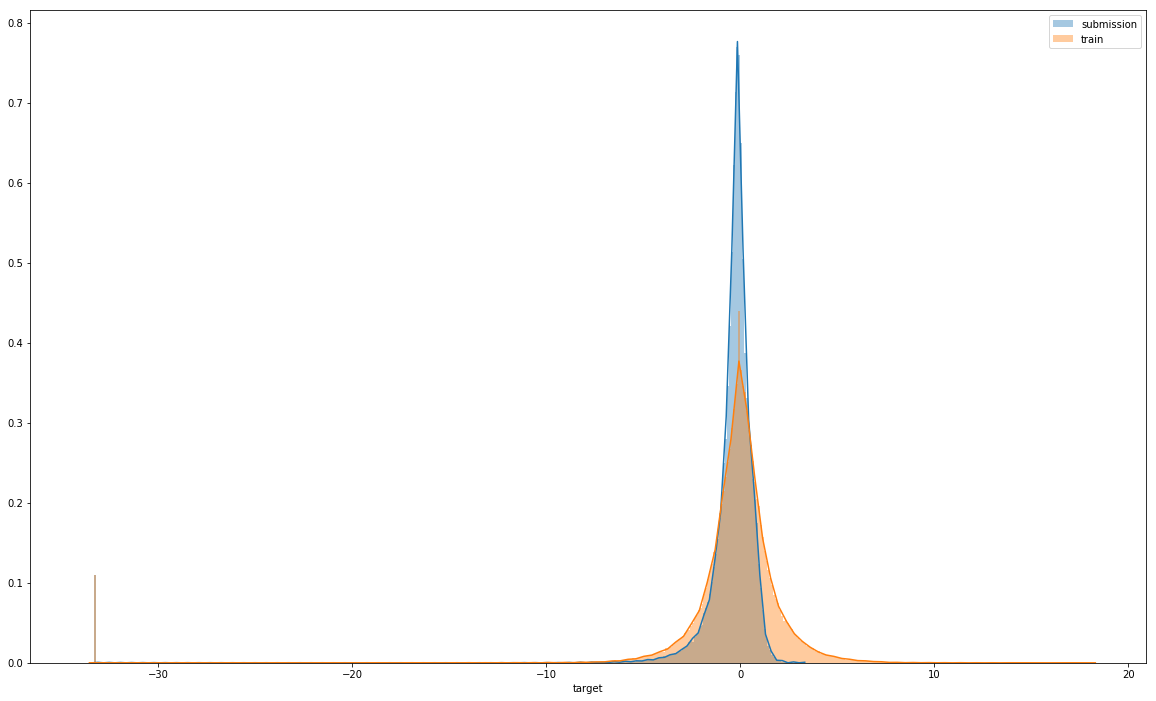

In [447]:
submit_with_lgbm(pr_test>0.6441,"submission15_6441_.csv")

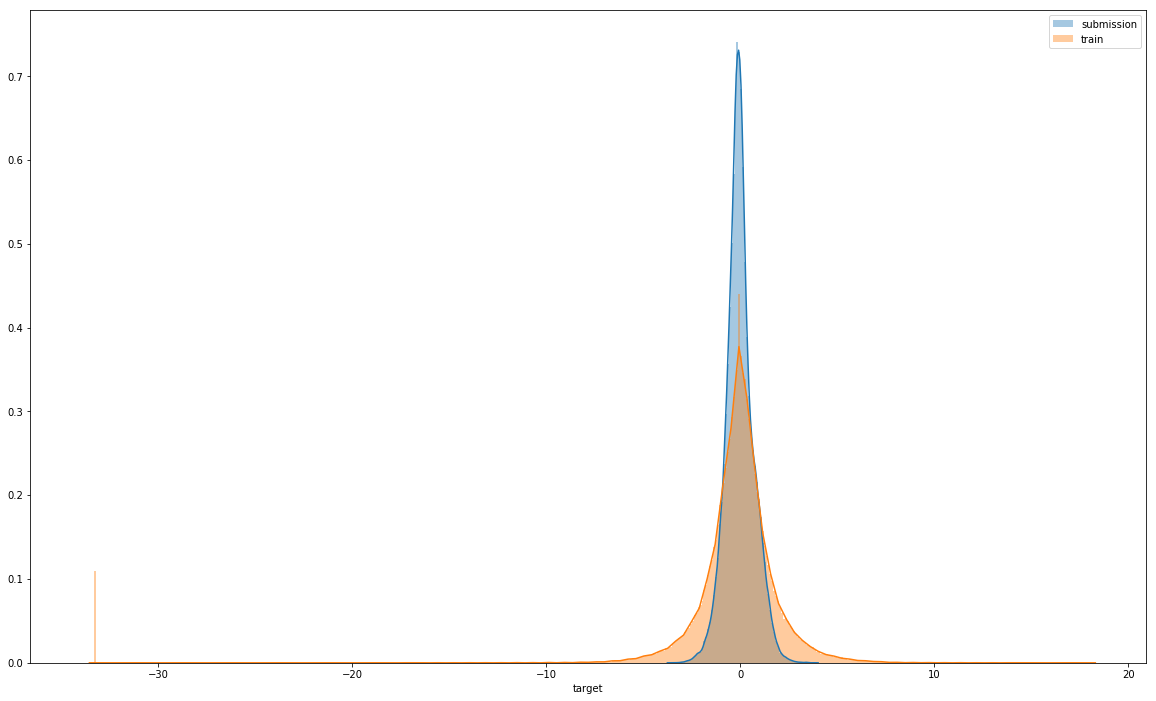

In [458]:
submit_with_lgbm(pr_test-1000,"submission16_without_31.csv")

In [459]:
pd.read_csv("submission16_without_31.csv")

,card_id,target
0,C_ID_0ab67a22ab,-0.531077
1,C_ID_130fd0cbdd,-0.302060
2,C_ID_b709037bc5,-0.704705
3,C_ID_d27d835a9f,-0.134831
4,C_ID_2b5e3df5c2,-1.387117
5,C_ID_5814b4f13c,0.598820
6,C_ID_a1b3c75277,0.245804
7,C_ID_f7cada36d3,1.022977
8,C_ID_9d2bc8dfc4,-0.603376
9,C_ID_6d8dba8475,-0.366050


In [443]:
(0.908+0.6441)/2

0.77605

In [436]:
(pr_test>0.77605).sum()

631

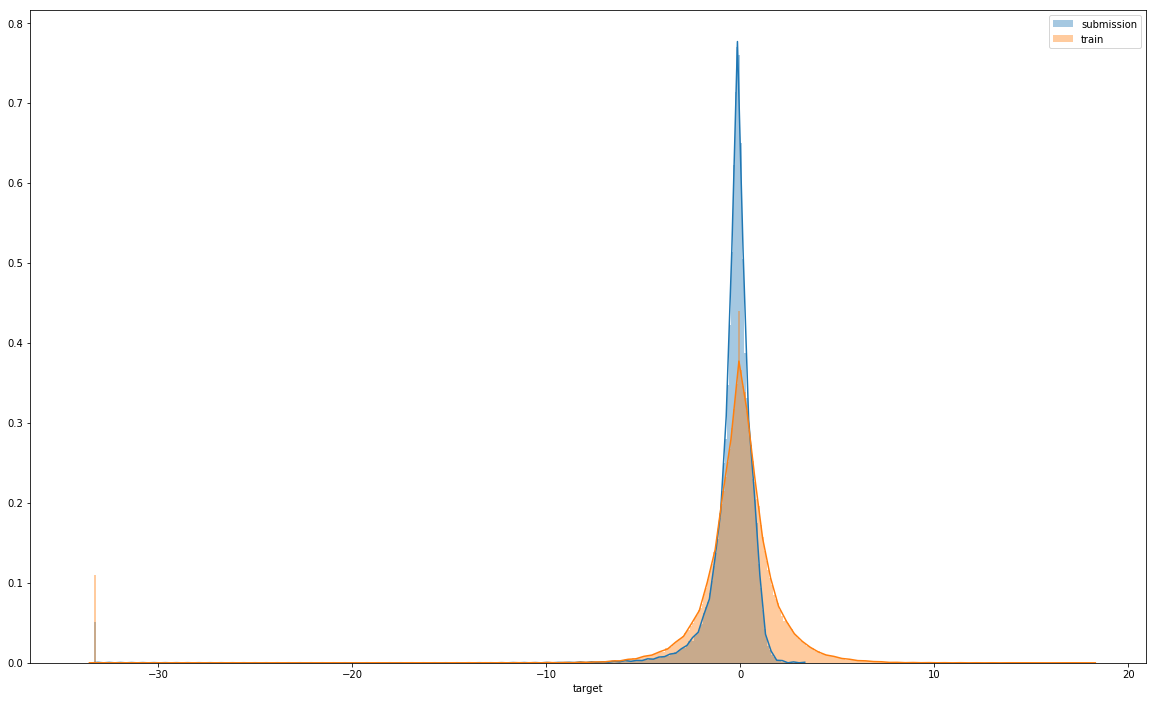

In [448]:
submit_with_lgbm(pr_test>0.77605,"submission15_77605_.csv")

In [420]:
b= 10000
for i in np.arange(0.89, 0.91, 0.0001):
    c =  confusion_matrix(pr>i, target_bool)
    if (c[0][1]+c[1][0]) < b: 
        b = (c[0][1]+c[1][0])
        t=i

In [421]:
b, t

(80, 0.907999999999998)

In [412]:
pd.read_csv("train.csv").target[np.argsort(pr)[::-1]]

25347    -33.219281
13101    -33.219281
100443   -33.219281
118541   -33.219281
197168   -33.219281
15807    -33.219281
89291    -33.219281
36224    -33.219281
162154   -33.219281
171585   -33.219281
3656     -33.219281
88034    -33.219281
183813   -33.219281
47385    -33.219281
25880    -33.219281
63849    -33.219281
134290   -33.219281
104394   -33.219281
83942    -33.219281
190324   -33.219281
16989    -33.219281
12602    -33.219281
33388    -33.219281
97496    -33.219281
176594   -33.219281
25272    -33.219281
132502   -33.219281
48324    -33.219281
69788    -33.219281
179088   -33.219281
            ...    
23877      0.941123
198710     0.230401
18784      1.160850
194986    -2.041701
64329     -0.300675
171295    -0.257652
91308     -0.199818
102229    -0.745523
88279      0.735475
97079      0.760579
194670    -0.083835
130188     1.806870
167216     0.771017
116305     0.091373
143408    -0.651277
37392      0.828133
19655      0.183249
189333    -1.176749
74027      5.005339


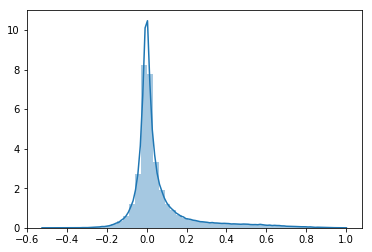

In [211]:
sns.distplot(predictions)

In [100]:
(predictions>0.8907).sum()

1171

In [104]:
predictions[predictions.argsort()][::-1][1351]

0.07951007884537675

In [232]:
(predictions>0.73).sum()

965

In [81]:
confusion_matrix(clf.predict(pd.read_csv("final_train.csv")[features], \
                    num_iteration=clf.best_iteration)>0.7931777953657507, \
                    pd.read_csv("target_less31_bool.csv", index_col=0, header=None))

array([[198403,     23],
       [  1307,   2184]])

In [349]:
cm1 = []
cm2 = []
cm3 = []
for t in np.linspace(0, 1, 100):
    cm = confusion_matrix(pre>t, target)
    cm1.append(cm[0][1])
    cm2.append(cm[1][0])
    cm3.append(cm[0][1]+cm[1][0])

In [358]:
cm = pd.DataFrame(index = np.linspace(0, 1, 100), columns=["cm1", "cm2", "cm3"])[["cm1", "cm2", "cm3"]]

In [359]:
cm["cm1"] = cm1
cm["cm2"] = cm2
cm["cm3"] = cm3

In [405]:
confusion_matrix(pre>0.955, target)

array([[199709,      0],
       [     1, 200837]])

In [331]:
def origin_data_test(clf, th = 0.5):
    train = pd.read_csv('final_train.csv', index_col=0)
    target = (pd.read_csv("train.csv")['target']<-30).astype("int")
    return confusion_matrix(clf.predict(train[features], num_iteration=clf.best_iteration)>th, target)

KeyboardInterrupt: 

In [ ]:
origin_data_test(clf)

In [406]:
confusion_matrix(clf.predict(train[features], num_iteration=clf.best_iteration)>0.955, target)

array([[199709,      0],
       [     1, 200837]])

In [408]:
confusion_matrix(clf.predict(pd.read_csv("final_train.csv")[features], num_iteration=clf.best_iteration)>0.955, target)

ValueError: Found input variables with inconsistent numbers of samples: [201917, 400547]

In [288]:
result = clf.predict(test[features])

In [291]:
np.save("test_cla_result2.ndarray", result)

In [289]:
cla_result = (result>0.5).astype("int")*(-33.219281) + (result<0.5).astype("int")*100

In [290]:
pd.value_counts(cla_result)

 100.000000    123417
-33.219281        206
dtype: int64

In [292]:
np.save("sum_cla2.ndarray", cla_result)

In [82]:
test = pd.read_csv("final_test.csv")

In [438]:
def submit_to_csv(result_array, submit_file):
    sub_df = pd.DataFrame(pd.read_csv("final_test.csv").card_id)
    sub_df["target"] = result_array
    sub_df.to_csv(submit_file, index=False)
    plt.figure(figsize=(20,12))
    sns.distplot(sub_df.target, bins=np.arange(-34, 16, 0.1), label='submission')
    sns.distplot(pd.read_csv("train.csv").target, bins=np.arange(-34, 16, 0.1), label='train')
    plt.legend()

In [446]:
lgb_drop_predictions = joblib.load('lgb_drop.pkl2').predict(pd.read_csv("final_test.csv")[features], \
                      num_iteration=joblib.load('lgb_drop.pkl2').best_iteration)
np.save("lgb_drop_predictions.npy",lgb_drop_predictions)

In [449]:
def submit_with_lgbm(result, submit_file):
    sub_df = pd.DataFrame()
    test_predictions = np.load("predictions_lgbm_without_31_1.npy")
    cla_result = (result>0.5).astype("int")*(-33.219281) + (result<0.5).astype("int")*100
    sub_df["cla_result"] = cla_result
    sub_df["predictions"] = test_predictions
    sub_df["submit"] = sub_df[["cla_result", "predictions"]].min(axis=1)
    submit_to_csv(sub_df["submit"], submit_file)

In [284]:
predictions = np.load("cla_logloss6.npy")

In [301]:
(predictions>0.129).sum()

1000

In [300]:
predictions[np.argsort(predictions)[::-1][1000]]

0.12897642707172216

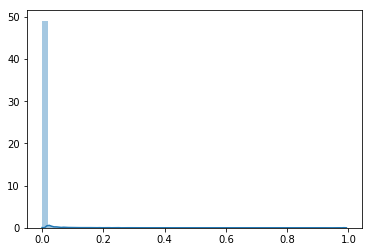

In [290]:
sns.distplot(predictions)

In [281]:
predictions.shape

(123623,)

In [305]:
(predictions>0.92).sum()

29

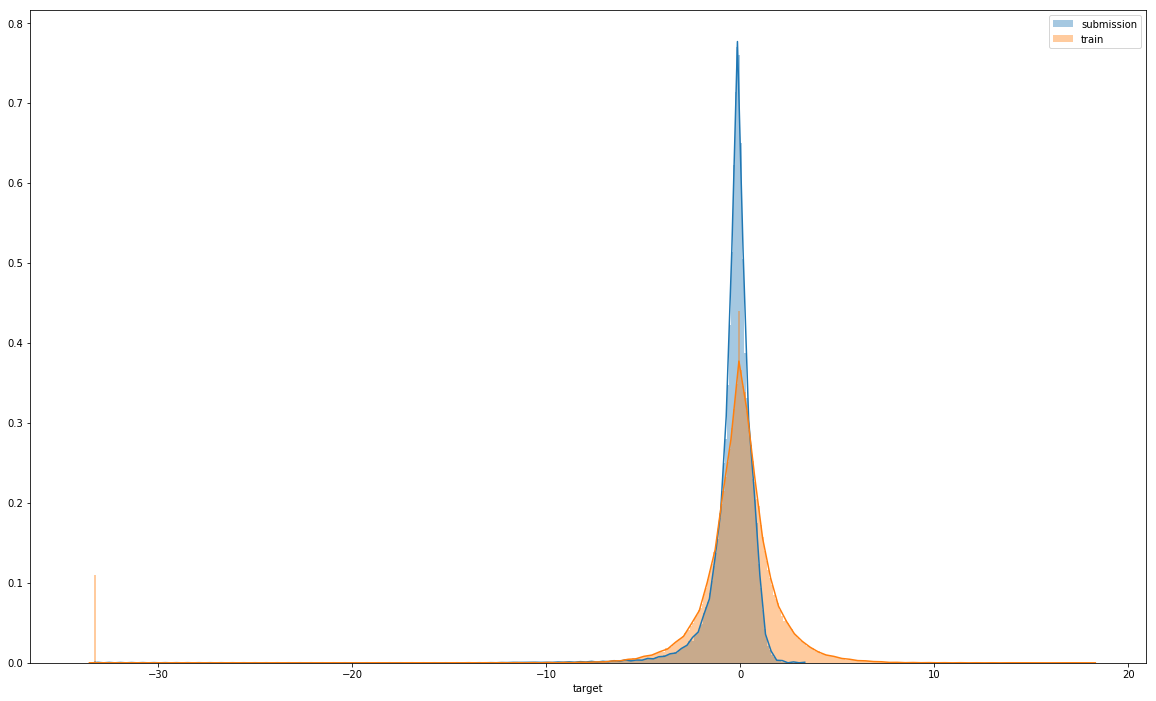

In [303]:
submit_with_lgbm( predictions>0.92,"submission13_92_.csv")

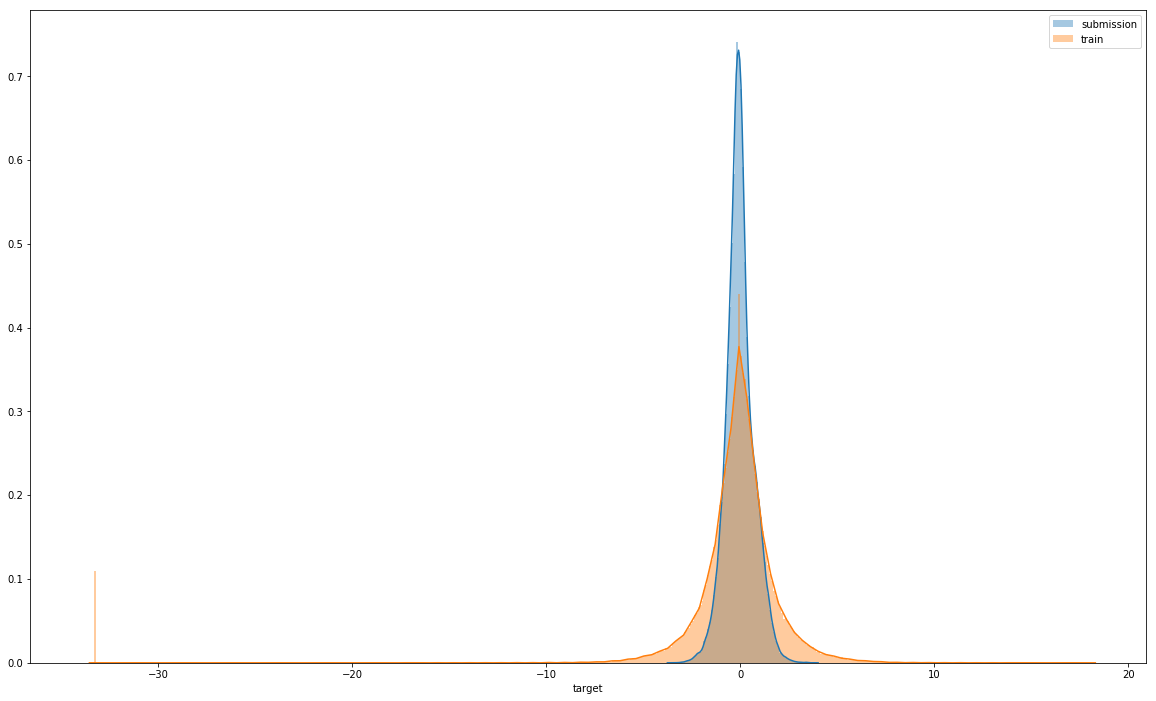

In [88]:
# submit_to_csv(np.load("predictions_lgbm_without_31_1.npy"), "submission8.csv")

In [656]:
pd.read_csv("test.csv").shape

(123623, 5)

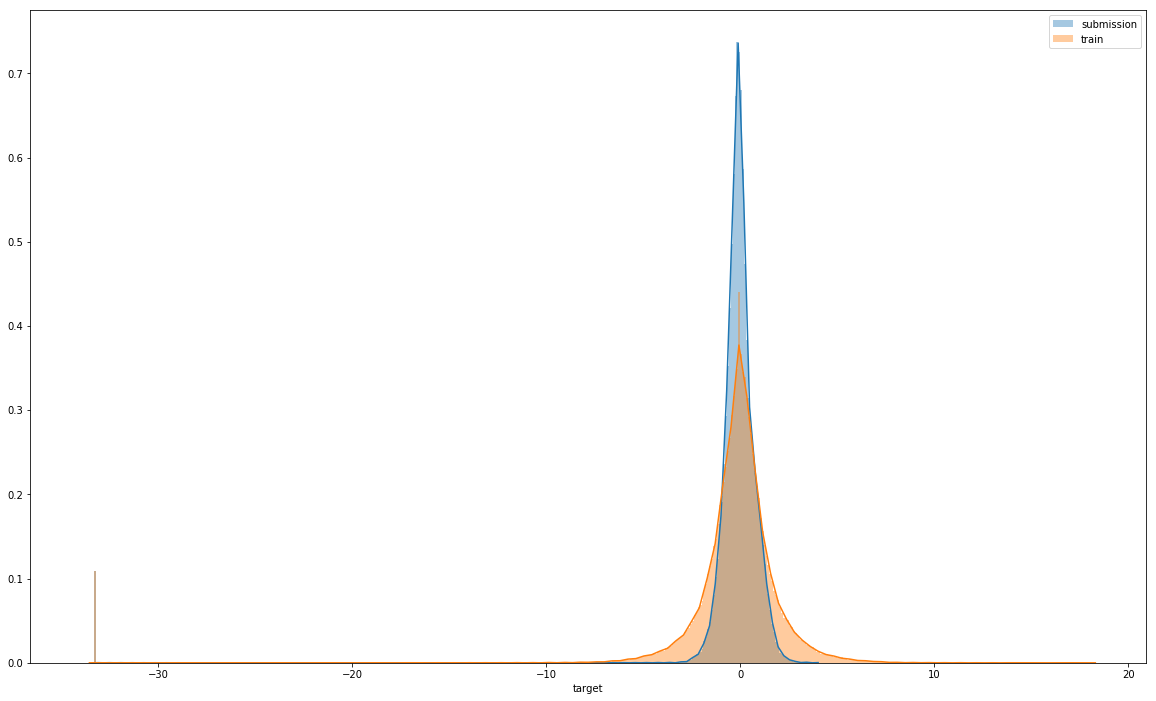

In [85]:
submit_with_lgbm((predictions>0.7931777953657507), "submission7.csv")

In [87]:
(pd.read_csv("submission7.csv",index_col=0).target<-30).sum()

1351

In [418]:
p = clf.predict(pd.read_csv("final_test.csv")[features], num_iteration=clf.best_iteration)

In [413]:
(pd.read_csv("train.csv").target<-30).sum()

2207

In [416]:
pd.read_csv("test.csv").count()

first_active_month    123622
card_id               123623
feature_1             123623
feature_2             123623
feature_3             123623
dtype: int64

In [417]:
2207/201917*123622

1351.2173516841078

In [421]:
p.sort()

In [432]:
p[::-1][1351]

0.22623448935476723

In [433]:
p[::-1][1350]

0.22639385458769573

In [435]:
pt = clf.predict(pd.read_csv("final_test.csv")[features], num_iteration=clf.best_iteration)

In [436]:
(pt>0.2263).sum()

1351

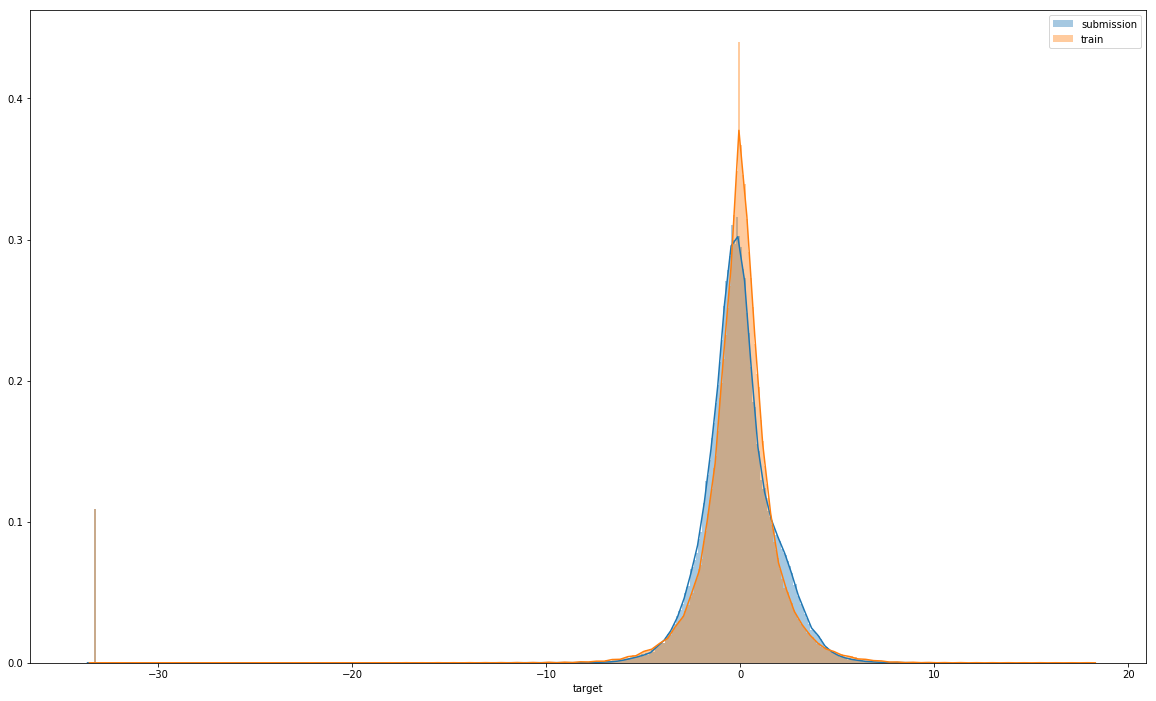

In [460]:
submit_with_lgbm(clf.predict(pd.read_csv("final_test.csv")[features], \
                             num_iteration=clf.best_iteration)>0.2263, "submission5_std_2263.csv")

In [454]:
pd.Series(lgb_drop_predictions)[pd.read_csv("train.csv").target>-30].std()

0.7258377116400868

In [458]:
pd.Series(lgb_drop_predictions*2.366634993486182)[pd.read_csv("train.csv").target>-30].std()

1.71779292795935

In [455]:
pd.read_csv("train.csv").target[pd.read_csv("train.csv").target>-30].std()

1.7177929279593622

In [456]:
1.7177929279593622/0.7258377116400868

2.366634993486182

In [452]:
lgb_drop_predictions

array([-0.51470933, -0.28376122, -0.61435344, ...,  1.07075238,
       -0.8600213 ,  0.20450965])

In [294]:
sub_df = pd.DataFrame(test.card_id)

In [296]:
test_predictions = joblib.load('lgb_drop.pkl2').predict(test[features], num_iteration=joblib.load('lgb_drop.pkl2').best_iteration)

In [295]:
sub_df["cla_result"] = cla_result
sub_df["cla_result"] 

0         100.0
1         100.0
2         100.0
3         100.0
4         100.0
5         100.0
6         100.0
7         100.0
8         100.0
9         100.0
10        100.0
11        100.0
12        100.0
13        100.0
14        100.0
15        100.0
16        100.0
17        100.0
18        100.0
19        100.0
20        100.0
21        100.0
22        100.0
23        100.0
24        100.0
25        100.0
26        100.0
27        100.0
28        100.0
29        100.0
          ...  
123593    100.0
123594    100.0
123595    100.0
123596    100.0
123597    100.0
123598    100.0
123599    100.0
123600    100.0
123601    100.0
123602    100.0
123603    100.0
123604    100.0
123605    100.0
123606    100.0
123607    100.0
123608    100.0
123609    100.0
123610    100.0
123611    100.0
123612    100.0
123613    100.0
123614    100.0
123615    100.0
123616    100.0
123617    100.0
123618    100.0
123619    100.0
123620    100.0
123621    100.0
123622    100.0
Name: cla_result, Length

In [297]:
sub_df["predictions"] = test_predictions
sub_df["predictions"]

0        -0.514709
1        -0.283761
2        -0.614353
3        -0.107774
4        -1.286803
5         0.684209
6         0.291856
7         0.991850
8        -0.727693
9        -0.363141
10       -0.630726
11        0.121853
12        0.158807
13       -0.001604
14       -0.269043
15        0.999744
16        0.416977
17       -0.022214
18        0.221099
19       -0.036588
20        0.136945
21       -0.690364
22        1.235656
23        0.251178
24       -0.129146
25        0.564134
26       -0.678302
27       -0.388615
28       -0.025524
29       -0.597130
            ...   
123593   -0.377060
123594   -1.463489
123595    0.076357
123596    1.255115
123597   -0.652566
123598   -0.441275
123599    0.618342
123600    0.034482
123601   -1.443397
123602   -0.185336
123603    0.038979
123604    0.799189
123605   -0.810803
123606   -0.234560
123607    0.673282
123608   -0.428860
123609   -0.065220
123610    0.408691
123611   -1.255123
123612   -0.592626
123613    0.150237
123614    1.

In [298]:
sub_df["submit"] = sub_df[["cla_result", "predictions"]].min(axis=1)

In [299]:
submission = pd.DataFrame(sub_df["card_id"])
submission["target"] = sub_df["submit"]

In [307]:
submission[submission["target"]<-30].count()

card_id    206
target     206
dtype: int64

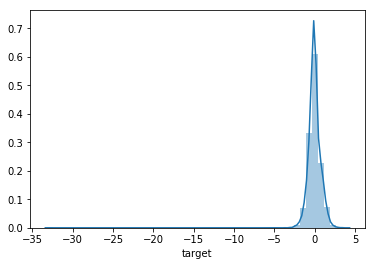

In [305]:
sns.distplot(submission.target)

In [107]:
!head submission.csv

card_id,target
C_ID_0ab67a22ab,-0.5147093309918691
C_ID_130fd0cbdd,-0.28376121866065535
C_ID_b709037bc5,-0.6143534355361029
C_ID_d27d835a9f,-0.10777433896873057
C_ID_2b5e3df5c2,-1.2868033050546757
C_ID_5814b4f13c,0.684209053164266
C_ID_a1b3c75277,0.2918555693941336
C_ID_f7cada36d3,0.9918501626482662
C_ID_9d2bc8dfc4,-0.7276931708877292


In [108]:
!tail submission.csv

C_ID_b588b35e15,0.150237180317028
C_ID_7147e348c3,1.2040384998396032
C_ID_727d3ec5da,-1.044701030013962
C_ID_107d93e20c,1.4450574232751638
C_ID_0e74bd4966,0.6717210687044655
C_ID_7a239d2eda,1.1071176637179527
C_ID_75ace375ae,-0.41242071555137394
C_ID_21d56d950c,1.0707523813575741
C_ID_6c46fc5a9d,-0.8600213018175061
C_ID_87e7979a5f,0.2045096470474171


In [105]:
!head sample_submission.csv

card_id,target
C_ID_0ab67a22ab,0
C_ID_130fd0cbdd,0
C_ID_b709037bc5,0
C_ID_d27d835a9f,0
C_ID_2b5e3df5c2,0
C_ID_5814b4f13c,0
C_ID_a1b3c75277,0
C_ID_f7cada36d3,0
C_ID_9d2bc8dfc4,0


In [109]:
!tail sample_submission.csv

C_ID_b588b35e15,0
C_ID_7147e348c3,0
C_ID_727d3ec5da,0
C_ID_107d93e20c,0
C_ID_0e74bd4966,0
C_ID_7a239d2eda,0
C_ID_75ace375ae,0
C_ID_21d56d950c,0
C_ID_6c46fc5a9d,0
C_ID_87e7979a5f,0


In [308]:
submission.to_csv("submission2.csv", index=False)

# Feature importance¶

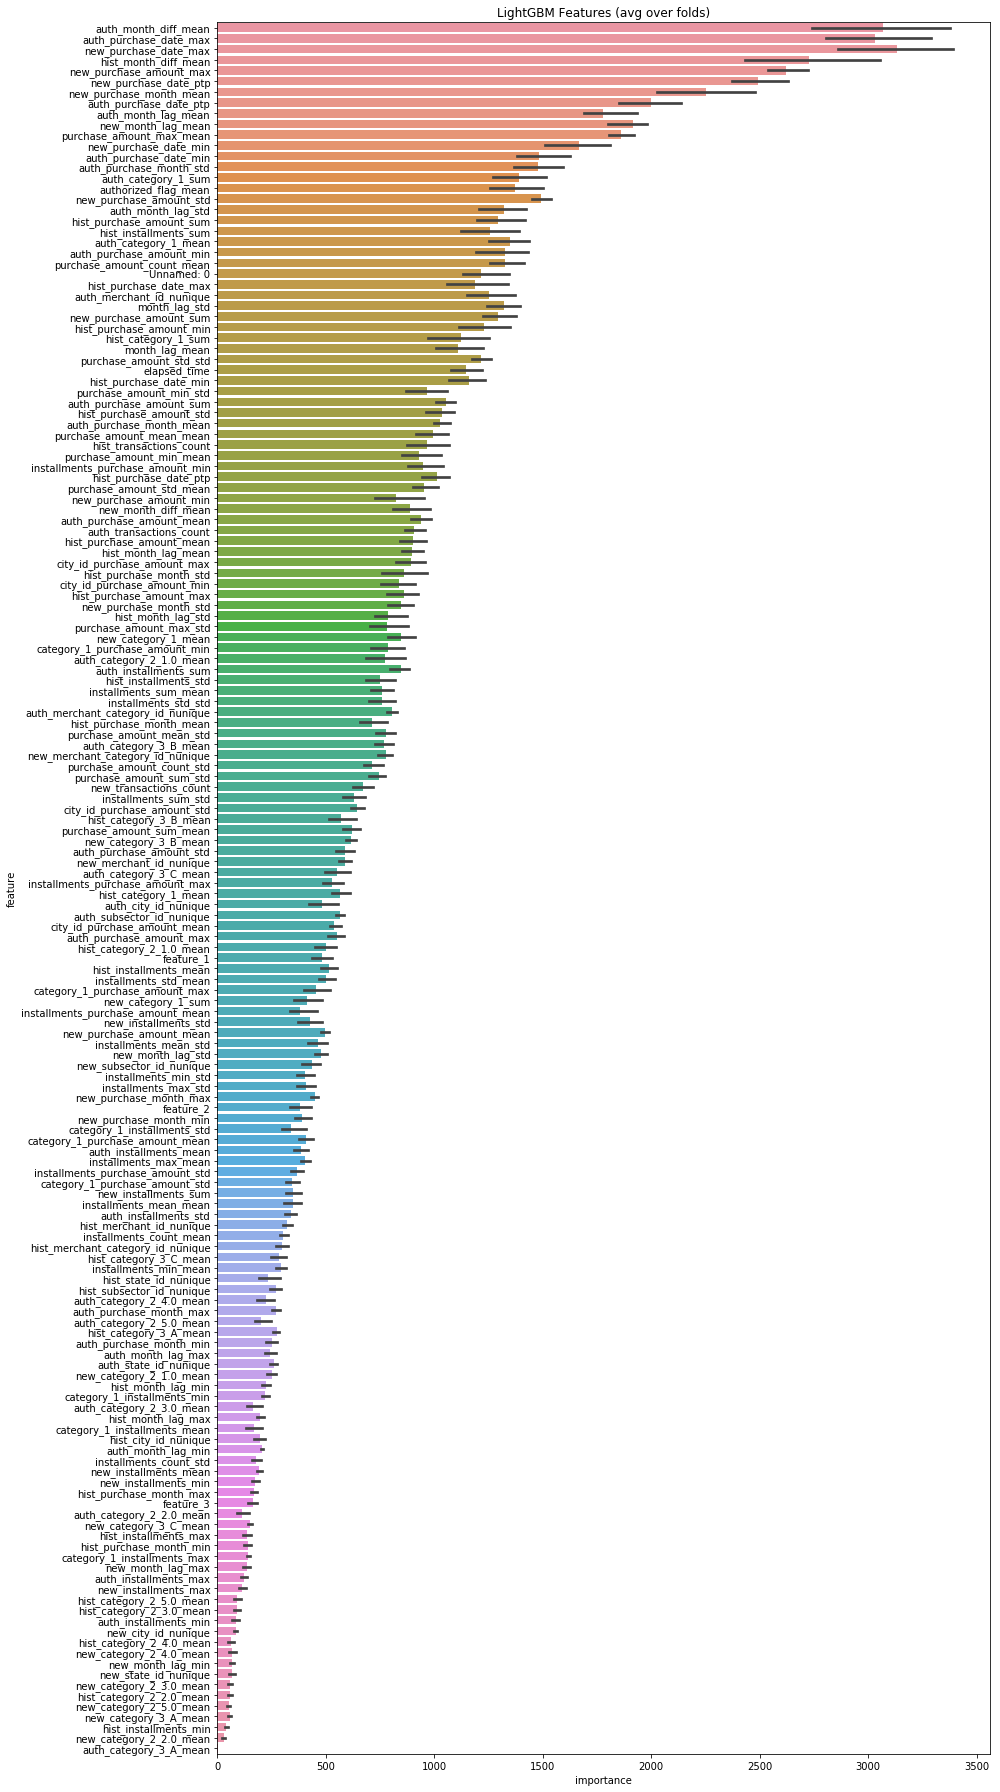

In [15]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [16]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [15]:
sub_df = pd.read_csv("submit.csv")

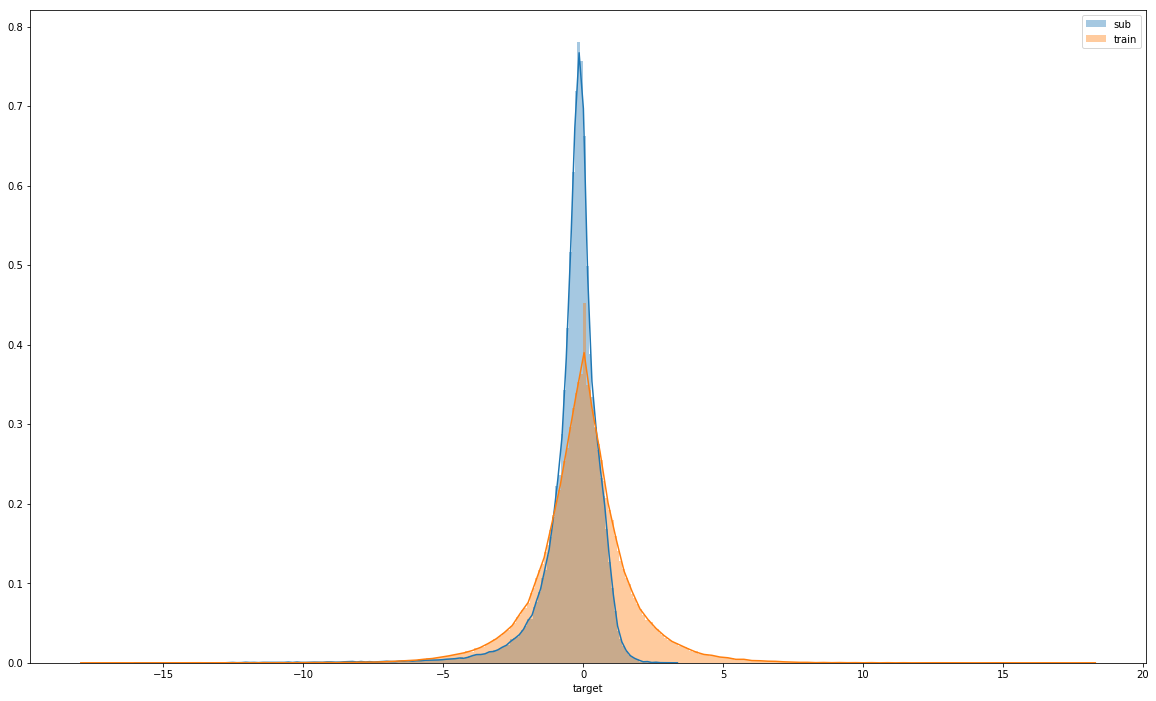

In [39]:
#train = pd.read_csv("train.csv", parse_dates=['first_active_month'])
plt.figure(figsize=(20,12))
sns.distplot(sub_df.target, bins=np.arange(-10, 10, 0.1), label='sub')
sns.distplot(train.target[train.target>-30], bins=np.arange(-10, 10, 0.1), label='train')
plt.legend()

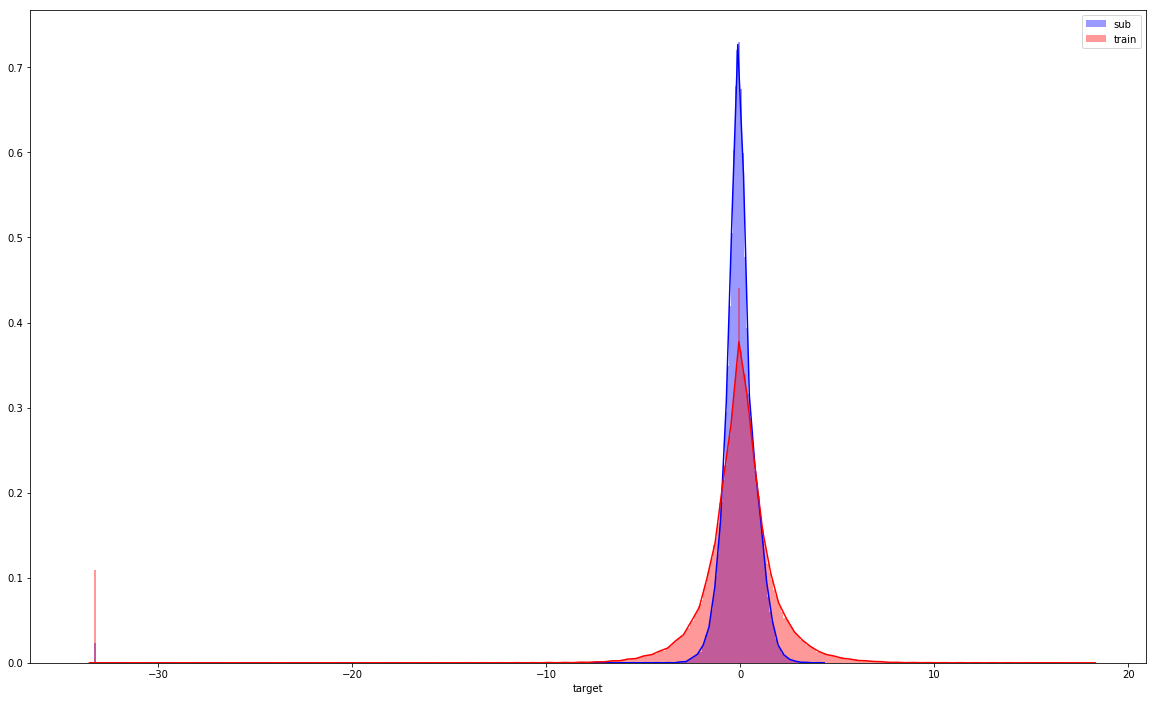

In [116]:
plt.figure(figsize=(20,12))
sns.distplot(submission.target, bins=np.arange(-34, 16, 0.1), label='sub', color="b")
sns.distplot(pd.read_csv("train.csv").target, bins=np.arange(-34, 16, 0.1), label='train', color="r")
plt.legend()

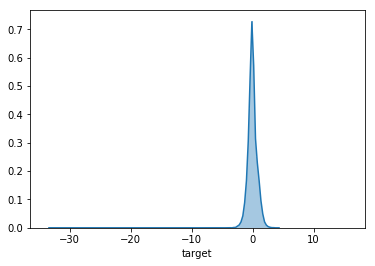

In [112]:
sns.distplot(submission.target, bins=np.arange(-34, 16, 0.1), label='sub')

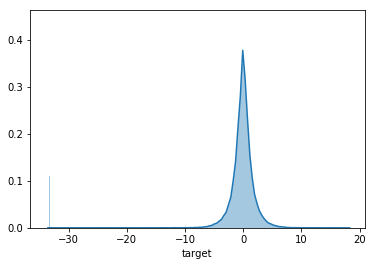

In [114]:
sns.distplot(pd.read_csv("train.csv").target, bins=np.arange(-34, 16, 0.1), label='train')

In [131]:
target.std()

1.7177929279593622

In [132]:
submission["target"].std()

1.7667418706984475

In [141]:
(submission["target"]<-30).sum() / submission["target"].shape[0]

0.0023620200124572287

In [188]:
final_train = pd.read_csv("final_train.csv")

In [193]:
target = pd.read_csv("train.csv")["target"]

In [143]:
(original_train["target"]<-30).sum() / original_train["target"].shape[0]

0.010930233709890698

In [180]:
lgb_drop = joblib.load("lgb_drop.pkl2")

In [194]:
train_less_31 = final_train[target<-30]

In [198]:
train_less_31_lgb_drop = lgb_drop.predict(train_less_31[features], num_iteration=lgb_drop.best_iteration)

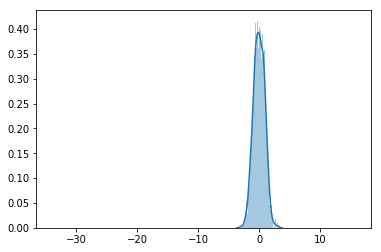

In [200]:
sns.distplot(train_less_31_lgb_drop , bins=np.arange(-34, 16, 0.1), label='train')

In [202]:
from xgboost.sklearn import XGBClassifier

In [ ]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'binary',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [222]:
xgbc = XGBClassifier(max_depth=9, learning_rate=0.01, n_estimators=500, 
                      silent=False, objective='binary:logistic', booster='gbtree', 
                      n_jobs=-1, nthread=8, gamma=0.1, 
                      reg_lambda=0.2634)

In [223]:
xgbc.fit(train_new[features], target_new, verbose=True )

[00:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=9
[00:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=9
[00:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=9
[00:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=9
[00:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=9
[00:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=9
[00:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=9
[00:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=9
[00:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned no

[00:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 4 pruned nodes, max_depth=9
[00:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 10 pruned nodes, max_depth=9
[00:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 4 pruned nodes, max_depth=9
[00:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 6 pruned nodes, max_depth=9
[00:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 8 pruned nodes, max_depth=9
[00:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 12 pruned nodes, max_depth=9
[00:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 8 pruned nodes, max_depth=9
[00:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 10 pruned nodes, max_depth=9
[00:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 2 pruned

[00:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 8 pruned nodes, max_depth=9
[00:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 2 pruned nodes, max_depth=9
[00:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 4 pruned nodes, max_depth=9
[00:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 6 pruned nodes, max_depth=9
[00:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 4 pruned nodes, max_depth=9
[00:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 8 pruned nodes, max_depth=9
[00:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=9
[00:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 10 pruned nodes, max_depth=9
[00:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 4 pruned n

[00:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 6 pruned nodes, max_depth=9
[00:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 4 pruned nodes, max_depth=9
[00:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 8 pruned nodes, max_depth=9
[00:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 4 pruned nodes, max_depth=9
[00:10:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 8 pruned nodes, max_depth=9
[00:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 2 pruned nodes, max_depth=9
[00:10:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 4 pruned nodes, max_depth=9
[00:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 6 pruned nodes, max_depth=9
[00:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 8 pruned no

[00:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 12 pruned nodes, max_depth=9
[00:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 8 pruned nodes, max_depth=9
[00:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 4 pruned nodes, max_depth=9
[00:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 6 pruned nodes, max_depth=9
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 4 pruned nodes, max_depth=9
[00:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 4 pruned nodes, max_depth=9
[00:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 2 pruned nodes, max_depth=9
[00:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 6 pruned nodes, max_depth=9
[00:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 4 pruned n

[00:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 10 pruned nodes, max_depth=9
[00:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 6 pruned nodes, max_depth=9
[00:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 2 pruned nodes, max_depth=9
[00:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 12 pruned nodes, max_depth=9
[00:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 4 pruned nodes, max_depth=9
[00:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 12 pruned nodes, max_depth=9
[00:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 2 pruned nodes, max_depth=9
[00:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 8 pruned nodes, max_depth=9
[00:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned

[00:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 2 pruned nodes, max_depth=9
[00:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 4 pruned nodes, max_depth=9
[00:16:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 4 pruned nodes, max_depth=9
[00:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 4 pruned nodes, max_depth=9
[00:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 8 pruned nodes, max_depth=9
[00:17:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 6 pruned nodes, max_depth=9
[00:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 6 pruned nodes, max_depth=9
[00:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 2 pruned nodes, max_depth=9
[00:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 4 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.01, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.2634, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [224]:
confusion_matrix(xgbc.predict(final_train[features]), target<-30)

array([[183148,      0],
       [ 16562,   2207]])

# xlearn